In [2]:
##!/usr/bin/python -tt 
# -*- coding: utf-8 -*-
%matplotlib inline
from __future__ import unicode_literals
from __future__ import print_function
import numpy as np
#import keras & tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score,accuracy_score
from tensorflow.keras import models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import itertools
import errno
import os
import cv2
import time
#from keras.utils.vis_utils import plot_model
from keras.callbacks import CSVLogger
from contextlib import redirect_stdout
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import LabelEncoder
#from keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report
from __future__ import unicode_literals
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import random
import datetime as dt 

###================== load image from filename
def loadData(path,valid=False):

    allFiles=[]
    allLabels=[]
    files = os.listdir( path )
    print('A number of complete files=',len(files))
    for fname in files:
        if fname.endswith('.PNG'):
            allFiles.append(os.path.join(path,fname))
            if fname.startswith('D'):
                allLabels.append(0)
            elif fname.startswith('N'):
                allLabels.append(1)
#                print(fname)          

    if valid:
        xTrain, X_test, yTrain, Y_test = train_test_split(allFiles, allLabels, test_size=0.4)
        xTest, xValid, yTest, yValid = train_test_split(X_test, Y_test, test_size=0.5)
        
        print('Test/Valid : %d'%(len(yValid)))
        print('Train : %d'%(len(yTrain)))
        del X_test, Y_test, allFiles, allLabels
        
        return xTrain, xValid, xTest, yTrain, yValid, yTest
    else:
        xTrain, xTest, yTrain, yTest = train_test_split(allFiles, allLabels, test_size=0.2)
        print('Test : %d'%(len(yTest)))
        print('Train : %d'%(len(yTrain)))
#        del xTrainT, yTrainT, xTestT, yTestT
        
        return xTrain, xTest, yTrain, yTest, allFiles, allLabels
      
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, listName, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True, train=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.cur_batch = 1
        self.n_samples = len(labels)
        self.train=train
        self.gen_augment(listName, labels)
        self.n_batch=int(np.floor(self.n_aug / self.batch_size))
        self.on_epoch_end()
        
    def gen_augment(self, listName_temp, labels_temp):
        # Initialization
        X = []
        y = []
        f = []
        # Generate data
        for i, fileName in enumerate(listName_temp):
            if self.n_channels==1:
                img = cv2.imread(fileName,0) # read image file , 0=Grayscale
            else:
                img = cv2.imread(fileName,1) # read image file 
            try:
                img = cv2.resize(img,(self.dim[0],self.dim[1]), interpolation = cv2.INTER_CUBIC).astype(np.float32)/255.0
#                print('img.shape=',img.shape)
            except:
                print("...image size error of %s..."%fileName)

            # Store sample
            X.append(np.asarray(img.reshape(self.dim[0], self.dim[1], self.n_channels)))
            num_aug=1
            
            if (self.train): # this is augmentation image for training set
                img_t=image.random_rotation(img, 90, row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_rotation(img, 180, row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_rotation(img, 270, row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_shear(img, 0.2, row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_shift(img, 0.2, 0.2, row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_zoom(img, (0.8,0.8), row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                img_t=image.random_zoom(img, (1.2,1.2), row_axis=0, col_axis=1)
                X.append(np.asarray(img_t.reshape(self.dim[0], self.dim[1], self.n_channels)))
                num_aug=8
            
            # Store class
            for j in range(num_aug):
                y.append(labels_temp[i])
                f.append(fileName)
                    
        self.n_aug=len(X)
        self.indexes = random.sample(list(range(self.n_aug)),self.n_aug)
        self.X = np.array(X)
        self.labels = np.array(y)
        self.fileName = np.array(f)
        del X, y, f
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.n_batch
    
    def getInfo(self):
        return self.X, self.labels, self.fileName
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_aug)

        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,]=self.X[ID]

            # Store class
            y[i] = self.labels[ID]

        return np.array(X), keras.utils.to_categorical(np.array(y), num_classes=self.n_classes)

In [6]:
###================== creat Basic CNN
def buildBasicModel1(input_shape):  
    model = keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(layters.Conv2D(64, (3, 3), activation='relu') )
    model.add(layters.MaxPooling2D(pool_size=(2, 2),strides=2))

    # fully connected dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'])    
    return model

###================== creat Lenet-5 CNN
def buildLenet5Model1(input_shape):  
    model = keras.Sequential()
    # C1 Convolutional Layer
    model.add(layers.Conv2D(6, kernel_size=(5, 5),strides=(1, 1), activation='tanh', input_shape=input_shape))
    # S2 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
#    model.add(Dropout(0.2))
    
    # C3 Convolutional Layer
    model.add(layers.Conv2D(16, kernel_size=(5, 5),strides=(1, 1), activation='tanh') )
    # S4 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2),strides=(2,2)))
#    model.add(Dropout(0.2))

    # C5 Fully Connected Convolutional Layer
    model.add(layers.Conv2D(120,  kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
#    model.add(Dropout(0.2))
    #Flatten the CNN output so that we can connect it with fully connected layers
    model.add(layers.Flatten())

    # FC6 Fully Connected Layer
    model.add(layers.Dense(84, activation='tanh'))
    #Output Layer with softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.SGD(),
        metrics=['accuracy'])    

    return model

###================== creat VGG16 CNN
# if do not use VGG16, you can use code as follow
def buildVGG16Model1(nput_shape,train=True):  
    model = keras.Sequential()
    # block1 Convolutional Layer
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # block2 Convolutional Layer
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # block3 Convolutional Layer
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last'))
    # block4 Convolutional Layer
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last'))
    # block5 Convolutional Layer
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last'))
    
    #Flatten the CNN output so that we can connect it with fully connected layers
    model.add(layers.Flatten())

    # FC6 Fully Connected Layer
    model.add(layers.Dense(1024, activation='relu')) # original model is: model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))  # original model is: model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    #Output Layer with softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))
    if train:
        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.SGD(),
            metrics=['accuracy'])    

    return model

# if use VGG16 from tensorflow, please import as follows
from tensorflow.keras.applications.vgg16 import VGG16
# please check the example code from keras

def buildVGGNet16(input_shape): 
    trainable=False
    conv_base=VGG16(include_top=False,input_tensor=None, input_shape=input_shape)
    conv_base.trainable = trainable
    for layer in conv_base.layers:
        layer.trainable = trainable
    top_model = keras.Sequential()
    top_model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
    top_model.add(layers.Dropout(0.3))
    top_model.add(layers.Dense(2, activation='sigmoid'))
    model = models.Model(inputs=conv_base.input, outputs=top_model(conv_base.output))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(),metrics=['accuracy'])
    
    return model

###================== creat ResNet-50 CNN
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.models import Model
def buildResNetModel1(input_shape):  
    trainable=False
    conv_base=ResNet50(include_top=False,input_tensor=None, input_shape=input_shape)
    conv_base.trainable = trainable
    for layer in conv_base.layers:
        layer.trainable = trainable
    top_model = keras.Sequential()
    top_model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
    top_model.add(layers.Dropout(0.3))
    top_model.add(layers.Dense(2, activation='sigmoid'))
    model = models.Model(inputs=conv_base.input, outputs=top_model(conv_base.output))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(),metrics=['accuracy'])
    
    return model

##================== creat Basic CNN M11 (as keras example)
def buildModelM71(input_shape):  
    model = keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same',data_format='channels_last') )
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))

    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding='same',data_format='channels_last') )
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding='same',data_format='channels_last') )
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))

    # fully connected dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    return model

###================== creat Basic CNN M11 (as keras example)
def buildMyModel(input_shape):  
    model = keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same',data_format='channels_last'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2,padding='same',data_format='channels_last'))
    model.add(layers.Dropout(0.2))

    # fully connected dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    #,kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
    return model

def generateEvaluationGraph(history,i):
    # Loss curves
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))    
    f.suptitle('Fold: '+str(i),fontsize=18)
    ax1.plot(history.history['loss'],'r',linewidth=3.0)
    ax1.plot(history.history['val_loss'],'b',linewidth=3.0)
    ax1.legend(['Training set', 'Validation set'],fontsize=16)
    ax1.set_xlabel('Epochs ',fontsize=16)
    ax1.set_ylabel('Loss',fontsize=16)
    ax1.set_title('Loss Curves',fontsize=16)
 
    # Accuracy Curves
    ax2.plot(history.history['accuracy'],'r',linewidth=3.0)
    ax2.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    ax2.legend(['Training set', 'Validation set'],fontsize=16)
    ax2.set_xlabel('Epochs ',fontsize=16)
    ax2.set_ylabel('Accuracy',fontsize=16)
    ax2.set_title('Accuracy Curves',fontsize=16)
    return f

### create model
def createModel(newpath,modelType='L5',input_shape=(224,224,3),epochs=30,load=False):
    if modelType=='L5':
        model = buildLenet5Model1(input_shape)
    elif modelType=='V16':
        model = buildVGG16Model1(input_shape)
    elif modelType=='My':
        model =buildMyModel(input_shape)
    elif modelType=='R50':
        model = buildResNetModel1(input_shape)
    elif modelType=='M71':
        model = buildModelM71(input_shape)
    
    # this use to stop early if you don't want to train all epochs
    #stop_here = EarlyStopping(monitor='val_loss',patience=5,verbose=0)
    if not load:
#         tf.keras.utils.plot_model(model, to_file=newpath+'model_plot.png', show_shapes=True, show_layer_names=True)
#         with open(newpath+'model_summary_m{}_b{}.txt'.format(modelType,batch_size), 'w') as f:
#             with redirect_stdout(f):
#                 model.summary()
        model.summary()

    return model

def trainModel(path, training_generator, validation_generator, modelType='L5',input_shape=(224,224,3),epochs=30,load=False):
    newpath=path+'result/result_m{}_b{}_{}/'.format(modelType,batch_size,dt.datetime.now().strftime('%Y%m%d_%H')) 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    model=createModel(newpath,modelType,input_shape,epochs)
    start=time.time()
    # Fit the model
    #    csv_logger = CSVLogger(newpath+'history%02d.log'%(i+1),append=True, separator=',') 
    csv_logger = CSVLogger(newpath+'history_m{}_b{}.log'.format(modelType,batch_size),append=False, separator=',') 
    history=model.fit(training_generator, validation_data=validation_generator,epochs=epochs,callbacks=[csv_logger])

    done = time.time()
    elapsed = done - start
    time_str=time.strftime("ETA of each round=%H:%M:%S\n", time.gmtime(elapsed))
    print(time_str)
    # serialize weights to HDF5
    model.save_weights(newpath+'model_m{}_b{}.h5'.format(modelType,batch_size))
    print("Saved model to disk")
    with open(newpath+'model_summary_m{}_b{}.txt'.format(modelType,batch_size),'a') as fi:
        fi.write('epochs=%d,time=%s'%(epochs,time_str))

    fig=generateEvaluationGraph(history,1)
    try:
        with PdfPages(newpath+'plot_m{}_b{}.pdf'.format(modelType,batch_size)) as pdf:
            pdf.savefig(fig)
    except ValueError:
        print('error save plot.pdf')

    return model, newpath, history

In [4]:
def testEvaluation(newpath, test_generator, model):
    print("Evaluate model...")
    score = model.evaluate(test_generator)
    print("Prediction model...")
    y_pred = model.predict(test_generator, verbose=1)

    loss=score[0]*100
    ac=score[1]*100
    print("\n%s: %.2f%%\t%s: %.2f%%" % (model.metrics_names[0], loss, model.metrics_names[1], ac))

    # predict test
    x,y,fname=test_generator.getInfo()
    y_pr=np.argmax(model.predict(x),axis=1)
    print(y)
    print(y_pr)
    n=len(y)
    print('n=',n)
    class_name=['F','T']

    acc=accuracy_score(y,y_pr)*100
    print('acc=',acc)

    # if you need to check predict result and groundtruth value
#     for i in range(n):
#         print(i,y[i],y_pr[i]) 

In [5]:
# main
###=========================== main
#path='D:/lemon_set/set01/crop02/'
# please design your dataset folder as in this study, folder of dataset for training is "crop05"
path='./crop05/'
valid=True
xTrain, xValid, xTest, yTrain, yValid, yTest=loadData(path,valid=valid)

seed = 7
np.random.seed(seed)
# Generate image and label
print('Generating images and labels...')
# input image dimensions , may be changed (original format is 224x224x3)
img_rows, img_cols, channel = 128, 128, 3  
num_classes=2
print('number of classes=',num_classes)
batch_size=64
# Parameters
params = {'dim': (img_rows,img_cols,channel),
          'batch_size': batch_size,
          'n_classes': num_classes,
          'n_channels': channel,
          'shuffle': True}

print('batch_size=',batch_size)
training_generator = DataGenerator(xTrain, np.array(yTrain), **params, train=True)
training_samples=training_generator.n_aug
print('A number of training samples=',training_samples)

if valid:
#    labels_valid=keras.utils.to_categorical(np.array(yValid), num_classes=num_classes)
    validation_generator = DataGenerator(xValid, np.array(yValid), **params, train=False)
    test_samples=len(yTest)
    validation_samples=len(yValid)
    print('A number of test samples=',test_samples)
    print('A number of validation samples=',validation_samples)
    del xValid, yValid
else:
#    labels_valid=keras.utils.to_categorical(np.array(yTest), num_classes=num_classes)
    validation_generator = DataGenerator(xTest, np.array(yTest) **params, train=False)
    validation_samples=len(yTest)
    print('A number of validation samples=',validation_samples)
                
del xTrain, yTrain

print('Finish to generate data...')

A number of complete files= 5711
Test/Valid : 1142
Train : 3426
Generating images and labels...
number of classes= 2
batch_size= 64
A number of training samples= 27408
A number of test samples= 1142
A number of validation samples= 1142
Finish to generate data...


input_shape= (128, 128, 3)
training....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 120)       48120     
_________________________________________________________________
flatten (Flatten)            (None, 75000)             0         
_________________________________________________________________
dense (Dense)   

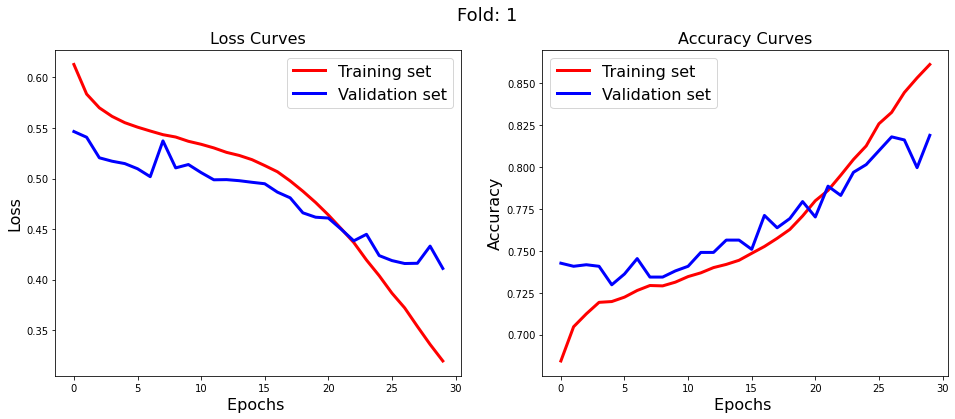

In [7]:
# train model use LeNet-5
tf.keras.backend.clear_session()
input_shape = (img_rows, img_cols, channel)
print('input_shape=',input_shape)
# epochs can be change 10, 20, 40, 50, ....
epochs = 30 
### start session on GPU, if gpu not found, program will run automatically on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

session_config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
print("training....")
modelType='L5' 

model, newpath, hist=trainModel(path, training_generator, validation_generator, modelType=modelType,input_shape=input_shape,epochs=epochs,load=False)

In [8]:
test_generator = DataGenerator(xTest, np.array(yTest), **params, train=False)
del xTest, yTest
test_samples=test_generator.n_aug
print('test_samples=',test_samples)
testEvaluation(newpath, test_generator, model)

test_samples= 1142
Evaluate model...
17/17 [==============================] - 0s 16ms/step - loss: 0.4110 - accuracy: 0.8226
Prediction model...
17/17 [==============================] - 0s 19ms/step

loss: 41.10%	accuracy: 82.26%
[1 0 0 ... 0 1 1]
[1 0 0 ... 0 0 1]
n= 1142
acc= 82.39929947460595


input_shape= (128, 128, 3)
training....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D

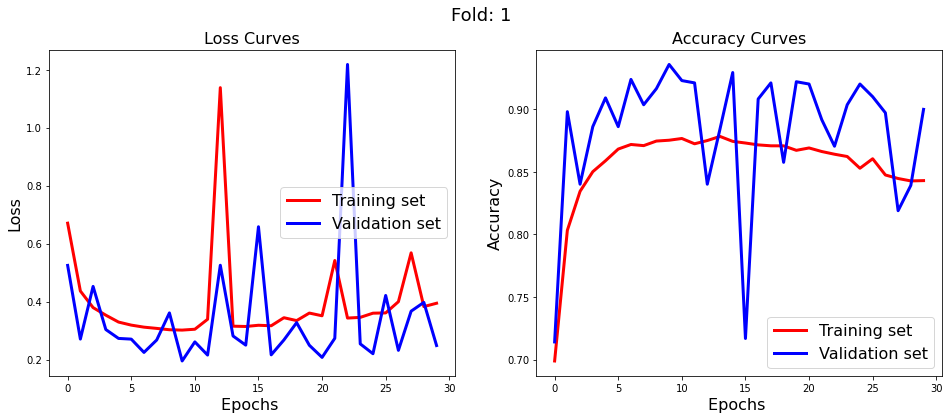

In [9]:
# train model use my architecture
tf.keras.backend.clear_session()
input_shape = (img_rows, img_cols, channel)
print('input_shape=',input_shape)
epochs = 30
### start session
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# please do not use the totality of the GPU memory
session_config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
print("training....")
modelType='My'
model, newpath, hist=trainModel(path, training_generator, validation_generator, modelType=modelType,input_shape=input_shape,epochs=epochs,load=False)

In [10]:
#test_generator = DataGenerator(xTest, np.array(yTest), **params, train=False)
#test_samples=test_generator.n_aug
print('test_samples=',test_samples)
testEvaluation(newpath, test_generator, model)

test_samples= 1142
Evaluate model...
17/17 [==============================] - 0s 17ms/step - loss: 0.2563 - accuracy: 0.8980
Prediction model...
17/17 [==============================] - 0s 18ms/step

loss: 25.63%	accuracy: 89.80%
[1 0 0 ... 0 1 1]
[1 1 0 ... 0 1 0]
n= 1142
acc= 89.66725043782837


input_shape= (128, 128, 3)
training....
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________

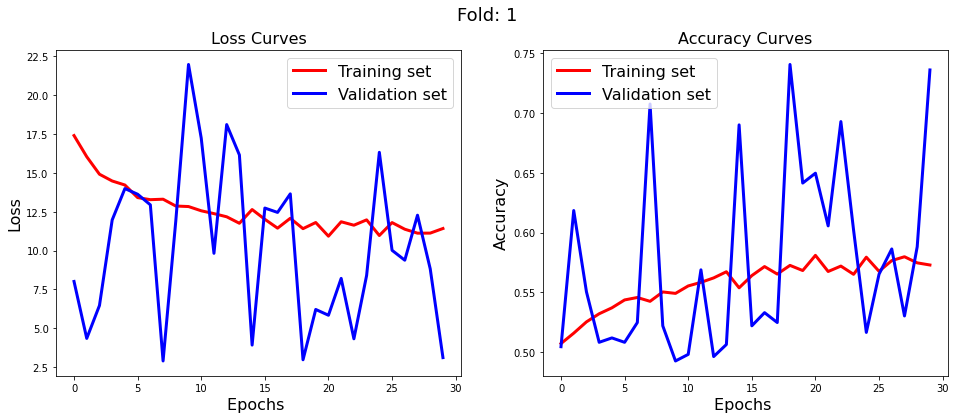

In [11]:
# train model use ResNet50
tf.keras.backend.clear_session()
input_shape = (img_rows, img_cols, channel)
print('input_shape=',input_shape)
epochs = 30
### start session
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# please do not use the totality of the GPU memory
session_config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
print("training....")
modelType='R50'
model, newpath, hist=trainModel(path, training_generator, validation_generator, modelType=modelType,input_shape=input_shape,epochs=epochs,load=False)

In [12]:
print('test_samples=',test_samples)
testEvaluation(newpath, test_generator, model)

test_samples= 1142
Evaluate model...
17/17 [==============================] - 1s 48ms/step - loss: 2.8565 - accuracy: 0.7381
Prediction model...
17/17 [==============================] - 1s 42ms/step

loss: 285.65%	accuracy: 73.81%
[1 0 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
n= 1142
acc= 74.16812609457094


input_shape= (128, 128, 3)
training....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 512)       590336    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       2359808   
_________________________________________________________________
max_pooling2d_2 

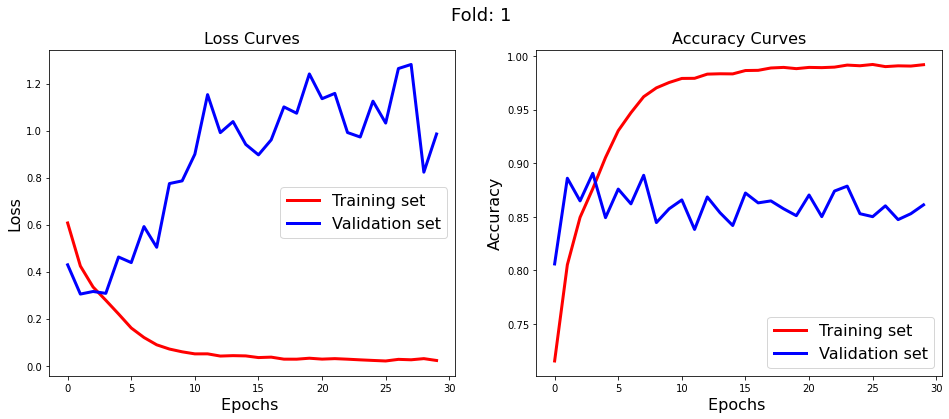

In [13]:
# train model use M71
tf.keras.backend.clear_session()
input_shape = (img_rows, img_cols, channel)
print('input_shape=',input_shape)
epochs = 30
### start session
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# please do not use the totality of the GPU memory
session_config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
print("training....")
modelType='M71'
model, newpath, hist=trainModel(path, training_generator, validation_generator, modelType=modelType,input_shape=input_shape,epochs=epochs,load=False)

In [14]:
print('test_samples=',test_samples)
testEvaluation(newpath, test_generator, model)

test_samples= 1142
Evaluate model...
17/17 [==============================] - 1s 36ms/step - loss: 0.9044 - accuracy: 0.8566
Prediction model...
17/17 [==============================] - 1s 31ms/step

loss: 90.44%	accuracy: 85.66%
[1 0 0 ... 0 1 1]
[1 0 0 ... 0 0 1]
n= 1142
acc= 85.90192644483362


input_shape= (128, 128, 3)
training....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D

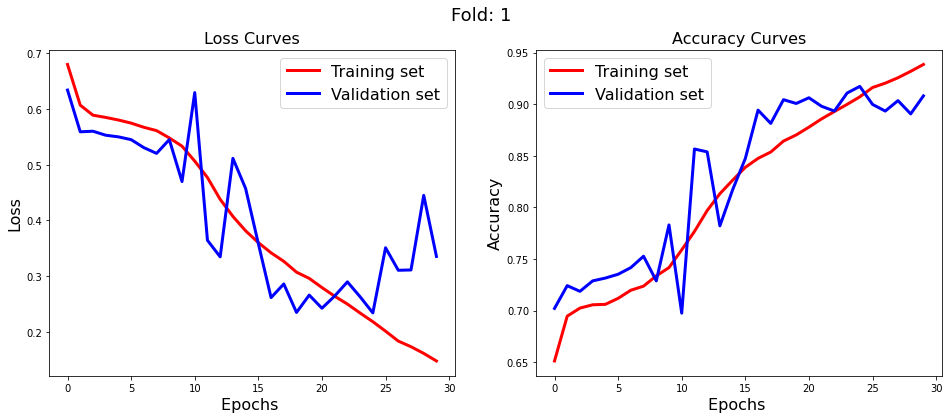

In [17]:
# train model use VGG16 but hyperparamer is reduced the hidden node from 4096 to 1024 at the final layer (FC6)
tf.keras.backend.clear_session()
input_shape = (img_rows, img_cols, channel)
print('input_shape=',input_shape)
epochs = 30
### start session
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# # please do not use the totality of the GPU memory
# session_config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# # please do not use the totality of the GPU memory
# session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
print("training....")
modelType='V16'
model, newpath, hist=trainModel(path, training_generator, validation_generator, modelType=modelType,input_shape=input_shape,epochs=epochs,load=False)

In [18]:
#test_generator = DataGenerator(xTest, np.array(yTest), **params, train=False)
#test_samples=test_generator.n_aug
print('test_samples=',test_samples)
testEvaluation(newpath, test_generator, model)

test_samples= 1142
Evaluate model...
17/17 [==============================] - 1s 40ms/step - loss: 0.3699 - accuracy: 0.8906
Prediction model...
17/17 [==============================] - 1s 38ms/step

loss: 36.99%	accuracy: 89.06%
[1 0 0 ... 0 1 1]
[1 0 0 ... 0 1 0]
n= 1142
acc= 88.96672504378283
